In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

import mir_eval
import numpy as np

from m2t.evaluation.utils import map_keys_to_giantsteps, VALID_KEYS

In [2]:
# os.chdir("/Users/joshg/projects/music2text/")

In [3]:
# # v3
# gs_key_pred = pd.read_csv("inference-results/v3/infer_results_giantsteps_key_v3_100k.csv")
# gs_tempo_pred = pd.read_csv("inference-results/v3/infer_results_giantsteps_tempo_v3_100k.csv")


# # v5
gs_key_pred = pd.read_csv("inference-results/v5/infer_results_giantsteps_key_v5_100000steps.csv")
gs_tempo_pred = pd.read_csv("inference-results/v5/infer_results_giantsteps_tempo_v5_100000steps.csv")

# imagebind-llm
# gs_key_pred = pd.read_csv("inference-results/baselines/imagebind-llm_giantsteps_key.csv")\
#     .rename(columns={'imagebind_llm_caption': 'model_completion_text'})
# gs_tempo_pred = pd.read_csv("inference-results/baselines/imagebind-llm_giantsteps_tempo.csv")\
#     .rename(columns={'imagebind_llm_caption': 'model_completion_text'})

# listen think understand
# gs_tempo_pred = pd.read_csv("inference-results/baselines/listen_think_understand_giantsteps_tempo.csv")\
#     .rename(columns={'ltu_caption': 'model_completion_text'})

# ablation study

# clap
# gs_key_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_key_clap_100000steps.csv")
# gs_tempo_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_tempo_clap_100000steps.csv")

# MPT
# gs_key_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_key_ablation-mpt1b_100000steps.csv")
# gs_tempo_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_tempo_ablation-mpt1b_100000steps.csv")

# 1% data
# gs_key_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_key_data-ablation-1pct_100000steps.csv")
# gs_tempo_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_tempo_data-ablation-1pct_100000steps.csv")

# 10% data
# gs_key_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_key_data-ablation-10pct_100000steps.csv")
# gs_tempo_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_tempo_data-ablation-10pct_100000steps.csv")

# 50% data
# gs_key_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_key_data-ablation-50pct_100000steps.csv")
# gs_tempo_pred = pd.read_csv("inference-results/ablations/infer_results_giantsteps_tempo_data-ablation-50pct_100000steps.csv")


In [4]:
gs_key_pred

,example_id,prompt_text,original_completion_text,model_completion_text
0,1092676_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is F minor.\n###
1,4328388_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is F minor.\n###
2,2680040_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is A minor.\n###
3,3935095_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is A minor.\n###
4,3667215_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is G# minor.\n###
...,...,...,...,...
597,4615188_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is G# minor.\n###
598,2031094_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is A minor.\n###
599,667508_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is D minor.\n###
600,511348_LOFI-start30_000-end60_000,<s> A chat between a curious human and an arti...,<EMPTY>\n###,The key of this song is E minor.\n###


In [5]:
gs_key_labels = pd.read_json("datasets/giantsteps/giantsteps-key.json", lines=True)
gs_tempo_labels = pd.read_json("datasets/giantsteps/giantsteps-tempo.json", lines=True)

In [6]:
(gs_tempo_labels['giantsteps_tempo']==0).sum()

3

In [7]:
def key_parse_fn(text:str)->str:
    """Extract the key from a string, if a key is present."""
    text = text.replace(' sharp', '#')
    text = text.replace('-sharp', '#')
    text = text.replace('sharp', '#')
    text = text.replace('-flat', 'b')
    res = re.search('[\w+#]+\smajor|[\w+#]+\sminor', text)
    if res is not None:
        return res.group()    
    else:
        return None
    
# print(key_parse_fn('The key of this song is A-flat major.'))
    
gs_key_pred['key_pred_parsed'] = gs_key_pred['model_completion_text'].map(key_parse_fn)

In [8]:
def id_parse_fn(text:str)->str:
    """Extract the ID of a track from its file name."""
    output = os.path.basename(text)
    output = output.replace(".npy", "")
    output = output.replace("-start30.000-end60.000", "")
    output = output.replace("-start30_000-end60_000", "")
    output = output.replace("_LOFI", ".LOFI")
    return output
gs_key_pred['id'] = gs_key_pred['example_id'].apply(id_parse_fn)

In [9]:
print(f"initial dataframe has {len(gs_key_labels)} labeled examples")
key_df = gs_key_labels.merge(gs_key_pred, on='id', how='inner')
print(f"merged dataframe has {len(key_df)} paired examples (prediction + label)")

initial dataframe has 604 labeled examples
merged dataframe has 602 paired examples (prediction + label)


In [10]:
key_df['key_pred_parsed'] = map_keys_to_giantsteps(key_df['key_pred_parsed'])

In [11]:
# baseline score
majority_class = key_df['giantsteps_key'].value_counts().idxmax()
scores = [mir_eval.key.evaluate(ref, majority_class)['Weighted Score']
          for ref in key_df['giantsteps_key']]
print(f"majority class score is {np.mean(scores)}")
# music2text scores
scores = [mir_eval.key.evaluate(ref, est)['Weighted Score'] if (est is not None and est in VALID_KEYS) else 0
          for ref, est in zip(key_df['giantsteps_key'], key_df['key_pred_parsed'])]

print(f"mirex score is {np.mean(scores)}")

majority class score is 0.15
mirex score is 0.6958471760797342


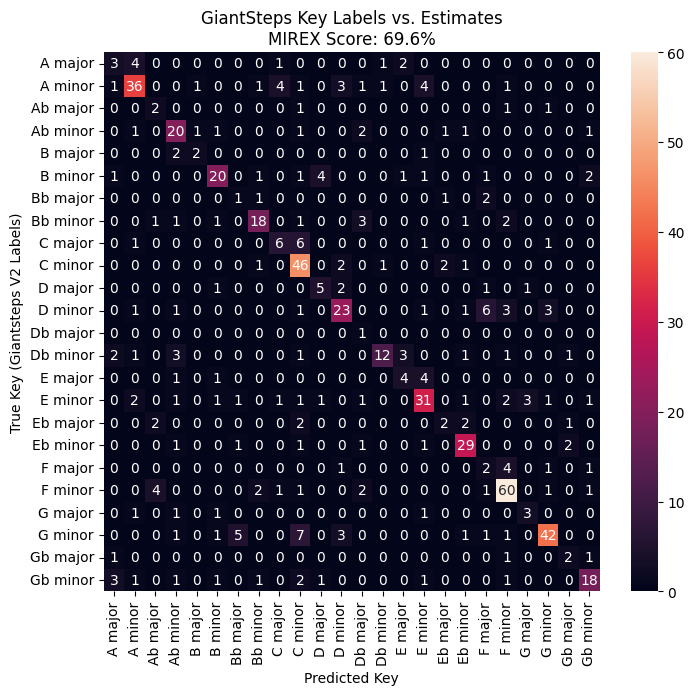

In [12]:
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))
key_matrix = pd.crosstab(key_df['giantsteps_key'], key_df['key_pred_parsed'])

sns.heatmap(key_matrix, annot=True, ax=ax)

ax.set(title=f'GiantSteps Key Labels vs. Estimates\n'
             f'MIREX Score: {np.mean(scores)*100:.1f}%',
      xlabel='Predicted Key', ylabel='True Key (Giantsteps V2 Labels)')
plt.savefig("confusion_matrix_key.pdf", bbox_inches="tight")

In [13]:
key_df[key_df.giantsteps_key==key_df.key_pred_parsed][['giantsteps_key', 'key_pred_parsed', 'example_id']].values[:99]

array([['F minor', 'F minor', '1092676_LOFI-start30_000-end60_000'],
       ['F minor', 'F minor', '4328388_LOFI-start30_000-end60_000'],
       ['A minor', 'A minor', '2680040_LOFI-start30_000-end60_000'],
       ['Ab minor', 'Ab minor', '3667215_LOFI-start30_000-end60_000'],
       ['G minor', 'G minor', '5039016_LOFI-start30_000-end60_000'],
       ['Bb minor', 'Bb minor', '4540971_LOFI-start30_000-end60_000'],
       ['F minor', 'F minor', '883724_LOFI-start30_000-end60_000'],
       ['C minor', 'C minor', '4361260_LOFI-start30_000-end60_000'],
       ['G minor', 'G minor', '3767408_LOFI-start30_000-end60_000'],
       ['D minor', 'D minor', '3772753_LOFI-start30_000-end60_000'],
       ['F minor', 'F minor', '2069519_LOFI-start30_000-end60_000'],
       ['F minor', 'F minor', '4945105_LOFI-start30_000-end60_000'],
       ['D minor', 'D minor', '4834156_LOFI-start30_000-end60_000'],
       ['F minor', 'F minor', '3249708_LOFI-start30_000-end60_000'],
       ['A major', 'A major', '

# Tempo

In [14]:
def tempo_parse_fn(text:str)->float:
    res = re.search('\d+(\.\d+)*', text)
    if res is not None:
        return float(res.group())
    else:
        return None

# gs_tempo_pred['model_completion_text'].tolist()
gs_tempo_pred['tempo_pred_parsed'] = gs_tempo_pred['model_completion_text'].apply(tempo_parse_fn)
print(f"got {pd.isnull(gs_tempo_pred['tempo_pred_parsed']).sum()} invalid tempo predictions.")

got 0 invalid tempo predictions.


In [15]:
gs_tempo_pred['id'] = gs_tempo_pred['example_id'].apply(id_parse_fn)

In [16]:
print(f"initial dataframe has {len(gs_tempo_labels)} labeled examples")
tempo_df = gs_tempo_labels.merge(gs_tempo_pred, on='id', how='inner')
tempo_df = tempo_df.query("giantsteps_tempo > 0")
print(f"merged dataframe has {len(tempo_df)} paired examples (prediction + label)")

initial dataframe has 664 labeled examples
merged dataframe has 661 paired examples (prediction + label)


In [17]:
from m2t.evaluation.utils import tempo_accuracy1,tempo_accuracy2

acc1 = tempo_accuracy1(ref=tempo_df['giantsteps_tempo'],
                     est=tempo_df['tempo_pred_parsed'])
acc2 = tempo_accuracy2(ref=tempo_df['giantsteps_tempo'],
                     est=tempo_df['tempo_pred_parsed'])
print(f'acc1 is {acc1}; acc2 is {acc2}')

is_correct.mean() is 0.0
checking multiplier 1
is_correct.mean() is 0.3313161875945537
checking multiplier 2
is_correct.mean() is 0.36459909228441756
checking multiplier 1/2
is_correct.mean() is 0.367624810892587
checking multiplier 3
is_correct.mean() is 0.367624810892587
checking multiplier 1/3
is_correct.mean() is 0.367624810892587
acc1 is 0.3313161875945537; acc2 is 0.367624810892587


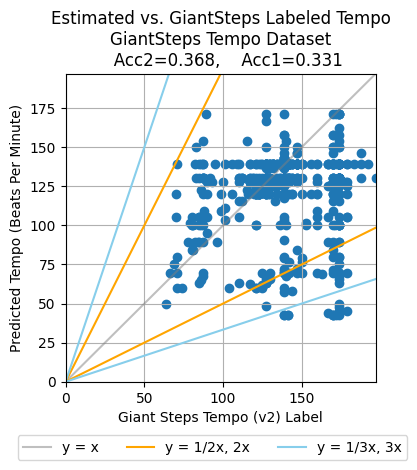

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

max_tempo = tempo_df[['giantsteps_tempo', 'tempo_pred_parsed']].max().max()

ax.scatter(tempo_df['giantsteps_tempo'], tempo_df['tempo_pred_parsed'])
ax.set(xlabel='Giant Steps Tempo (v2) Label',
       ylabel='Predicted Tempo (Beats Per Minute)',
      xlim=(0, max_tempo),
      ylim=(0, max_tempo),
      title='Estimated vs. GiantSteps Labeled Tempo'
       '\nGiantSteps Tempo Dataset'
       f'\n   Acc2={acc2:.3f},    Acc1={acc1:.3f}'
      )
ax.grid()
ax.axline((0,0), slope=1, label='y = x', color='grey', alpha=0.5)
ax.axline((0,0), slope=0.5, label='y = 1/2x, 2x', color='orange')
ax.axline((0,0), slope=2, color='orange')
ax.axline((0,0), slope=3, label='y = 1/3x, 3x', color='skyblue')
ax.axline((0,0), slope=1/3, color='skyblue')

ax.legend(bbox_to_anchor=(1.125, -0.15), ncol=3)
plt.savefig("notebooks/tempo_plot.pdf", bbox_inches="tight")

In [19]:
tempo_df['abs_err'] = np.abs(tempo_df['giantsteps_tempo'] - tempo_df['tempo_pred_parsed'])
tempo_df[['giantsteps_tempo', 'tempo_pred_parsed', 'abs_err', 'example_id']].sort_values('abs_err').values[:199]

array([[125, 125.0, 0.0, '3807114_LOFI-start30_000-end60_000'],
       [120, 120.0, 0.0, '2751688_LOFI-start30_000-end60_000'],
       [130, 130.4, 0.4000000000000057,
        '2759853_LOFI-start30_000-end60_000'],
       [140, 139.5, 0.5, '4038987_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4735758_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4475855_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '365981_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4323506_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4937390_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4826952_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '5363251_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4921810_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '4145229_LOFI-start30_000-end60_000'],
       [139, 139.5, 0.5, '1626348_LOFI-start30_000-end60_000'],
       [140, 139.5, 0.5, '3475669_LOFI-start30_000-end60_000'],
       [139, 139.5

In [416]:
tempo_df['tempo_pred_parsed'].value_counts().sort_values()

44.4       1
50.4       1
42.6       1
48.0       1
60.0       1
61.9       1
162.2      1
72.3       1
133.3      2
142.9      2
136.4      2
67.4       2
115.4      3
105.3      3
45.1       3
157.9      4
150.0      8
122.4     12
125.0     16
89.6      18
171.4     19
80.0      25
69.8      30
100.0     41
127.7     48
130.4     71
120.0    126
139.5    218
Name: tempo_pred_parsed, dtype: int64

In [417]:
import numpy as np
np.corrcoef(tempo_df[['giantsteps_tempo','tempo_pred_parsed']], rowvar=False)

array([[1.        , 0.07217798],
       [0.07217798, 1.        ]])

# Madmom Baselines

In [418]:
from m2t.dataset_utils import read_jsonl_data
madmom_results_key = read_jsonl_data("/Users/joshg/projects/music2text/datasets/giantsteps/key/annotated/*jsonl")

read /Users/joshg/projects/music2text/datasets/giantsteps/key/annotated/*jsonl: 100%|█


In [419]:
madmom_results_key['key'] = map_keys_to_giantsteps(madmom_results_key['key'])

NameError: name 'madmom_results' is not defined

In [ ]:
scores = [mir_eval.key.evaluate(ref, est)['Weighted Score']
          for ref, est in zip(madmom_results_key['giantsteps_key'], madmom_results_key['key'])]

print(f"madmom key score is {np.mean(scores)}")